<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Load-Data-and-Prepare-for-Training" data-toc-modified-id="Load-Data-and-Prepare-for-Training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data and Prepare for Training</a></span></li><li><span><a href="#Define-Model-Architecture-(cGAN)" data-toc-modified-id="Define-Model-Architecture-(cGAN)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define Model Architecture (cGAN)</a></span><ul class="toc-item"><li><span><a href="#Discriminator" data-toc-modified-id="Discriminator-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Discriminator</a></span></li><li><span><a href="#Generator" data-toc-modified-id="Generator-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generator</a></span></li><li><span><a href="#Combined-GAN" data-toc-modified-id="Combined-GAN-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Combined GAN</a></span></li></ul></li><li><span><a href="#Define-Helper-Functions" data-toc-modified-id="Define-Helper-Functions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Define Helper Functions</a></span></li><li><span><a href="#Model-Training-(cGAN)" data-toc-modified-id="Model-Training-(cGAN)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Training (cGAN)</a></span></li><li><span><a href="#Define-Model-Architecture-(Encoder)" data-toc-modified-id="Define-Model-Architecture-(Encoder)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Define Model Architecture (Encoder)</a></span><ul class="toc-item"><li><span><a href="#Define-Encoder" data-toc-modified-id="Define-Encoder-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Define Encoder</a></span></li><li><span><a href="#Define-Helper-Functions" data-toc-modified-id="Define-Helper-Functions-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Define Helper Functions</a></span></li><li><span><a href="#Build-Encoder" data-toc-modified-id="Build-Encoder-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Build Encoder</a></span></li></ul></li><li><span><a href="#Model-Training-(Encoder)" data-toc-modified-id="Model-Training-(Encoder)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Model Training (Encoder)</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></div>

# Setup

In [ ]:
import csv
import datetime
import io
import os
import time
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import Input, Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model, save_model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.utils import load_img, img_to_array
from numpy import asarray, ones, zeros,  load, savez_compressed
from numpy.random import randn, randint
from scipy.io import loadmat
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (BatchNormalization, Concatenate, Conv2D, Conv2DTranspose, Dense, Dropout, Embedding, Flatten, LeakyReLU, Reshape)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(tf.__version__)

2.12.0


In [ ]:
! nvidia-smi

Sun May  7 09:36:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Data and Prepare for Training


In [ ]:
# load data

base_path = "/path/256/data/"

images_train = load(base_path + 'train_images.npz')['arr_0']
images_test = load(base_path + 'test_images.npz')['arr_0']

hs_train = load(base_path + 'hs_train.npz')['arr_0']
hs_test = load(base_path + 'hs_test.npz')['arr_0']

bmi_train = load(base_path + 'bmi_train.npz')['arr_0']
bmi_test = load(base_path + 'bmi_test.npz')['arr_0']

In [ ]:
# define function to exclude entreis with a BMI < 24
def remove_entries(image_array, attr1_array, attr2_array, threshold):
    # Use np.where to get indices where attr1_array > threshold
    indices = np.where(attr1_array > threshold)
    
    # Use the indices to update the arrays
    updated_image_array = image_array[indices]
    updated_attr1_array = attr1_array[indices]
    updated_attr2_array = attr2_array[indices]

    # Reshape the updated image array
    updated_image_array = updated_image_array.reshape((len(updated_attr1_array), 256, 256, 3))

    # Return the updated arrays
    return updated_image_array, updated_attr1_array, updated_attr2_array

In [ ]:
# exclude entreis with a BMI < 24
images_train, bmi_train, hs_train = remove_entries(images_train, bmi_train, hs_train, 24)
images_test, bmi_test, hs_test = remove_entries(images_test, bmi_test, hs_test, 24)

In [ ]:
print('Prepared: ', images_train.shape)
print('Prepared: ', hs_train.shape)
print('Prepared: ', bmi_train.shape)
print('Prepared: ', images_test.shape)
print('Prepared: ', hs_test.shape)
print('Prepared: ', bmi_test.shape)

Prepared:  (37004, 256, 256, 3)
Prepared:  (37004,)
Prepared:  (37004,)
Prepared:  (9276, 256, 256, 3)
Prepared:  (9276,)
Prepared:  (9276,)


In [ ]:
# define functio to standardize HS values
def standardize_array(arr):
    print(f"Before: {arr[:1]}")
    mean = np.mean(arr)
    std = np.std(arr)
    standardized_arr = (arr - np.mean(arr)) / np.std(arr)
    print(f"After: {standardized_arr[:1]}")
    return standardized_arr, mean, std

In [ ]:
# standardize health score values
hs_train, hs_train_mean, hs_train_std = standardize_array(hs_train)

Before: [428]
After: [-1.84143219]


In [ ]:
print(hs_train_mean, hs_train_std)

478.68800670197817 27.52640414253601


In [ ]:
# define functio to invert standatization again
def invert_standardization(standardized_arr, mean = hs_train_mean, std = hs_train_std):
    inverted_arr = standardized_arr * std + mean
    return inverted_arr

# Define Model Architecture (cGAN)

## Discriminator

In [ ]:
def define_discriminator(in_shape=(256,256,3)):
    # define label input (single value)
    in_label = Input(shape=(1,))
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1] 
    # fully connected layer to generate a channel for the label input
    li = Dense(n_nodes)(in_label) 
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li) 

    # image input
    in_image = Input(shape=in_shape) 
    # concat label as a channel
    merge = Concatenate()([in_image, li]) 

    # downsample image
    # first convolutional layer
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same')(merge) 
    # apply leaky relu activation function
    fe = LeakyReLU(alpha=0.2)(fe)
    
    # first convolutional layer
    fe = Conv2D(64, (3,3), strides=(2,2), padding='same')(fe) 
    # apply leaky relu activation function
    fe = LeakyReLU(alpha=0.2)(fe)
    
    # second convolutional layer
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) 
    # apply leaky relu activation function
    fe = LeakyReLU(alpha=0.2)(fe)
    
    # third convolutional layer
    fe = Conv2D(256, (3,3), strides=(2,2), padding='same')(fe)
    # apply leaky relu activation function
    fe = LeakyReLU(alpha=0.2)(fe)
    
    # fourth convolutional layer
    fe = Conv2D(512, (3,3), strides=(2,2), padding='same')(fe) 
    # apply leaky relu activation function
    fe = LeakyReLU(alpha=0.2)(fe)
    
    # fifth convolutional layer
    fe = Conv2D(1024, (3,3), strides=(2,2), padding='same')(fe) 
    # apply leaky relu activation function
    fe = LeakyReLU(alpha=0.2)(fe)


    # flatten feature maps
    fe = Flatten()(fe)
    # dropout to prevent overfitting
    fe = Dropout(0.2)(fe)
    # output layer with a single node and sigmoid activation
    out_layer = Dense(1, activation='sigmoid')(fe)  

    # define the model with image and label inputs and output
    model = Model([in_image, in_label], out_layer)
    # compile the model with binary cross-entropy loss and Adam optimizer
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
discriminator = define_discriminator()
print(discriminator.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 65536)        131072      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 reshape (Reshape)              (None, 256, 256, 1)  0           ['dense[0][0]']              

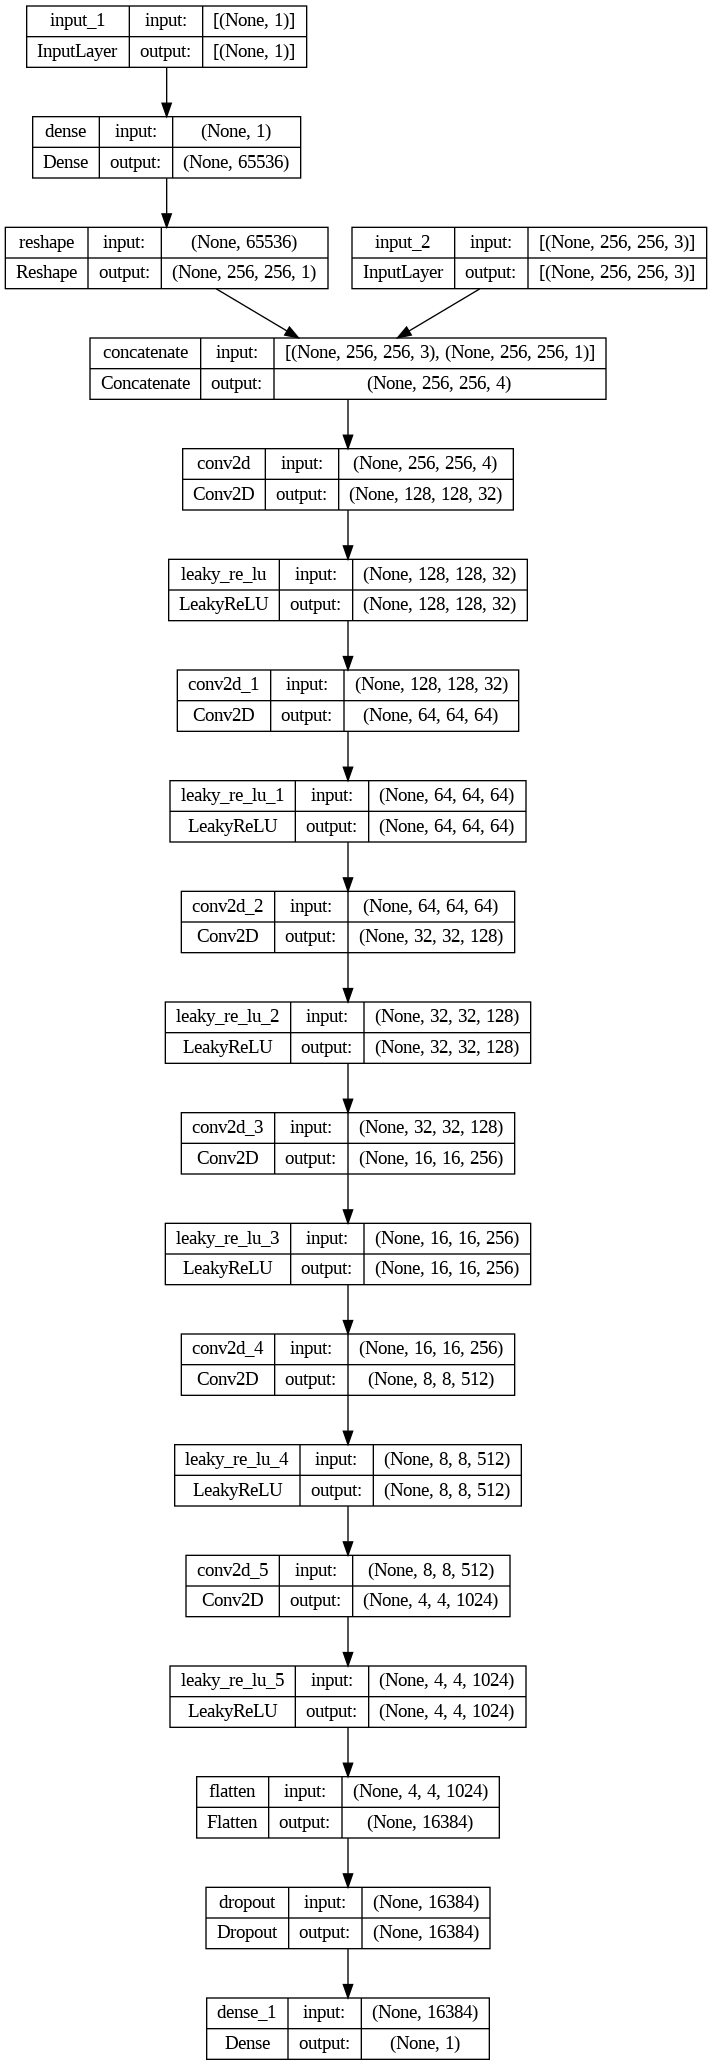

In [ ]:
# Visualize the model architecture
plot_model(discriminator, show_shapes=True, show_layer_names=True)

## Generator

In [ ]:
def define_generator(latent_dim):
    # label input
    in_label = Input(shape=(1,))

    # linear multiplication
    n_nodes = 8 * 8 * 1
    li = Dense(n_nodes)(in_label)
    
    # reshape to additional channel
    li = Reshape((8, 8, 1))(li)

    # image generator input
    in_lat = Input(shape=(latent_dim,))

    # foundation for 8x8 image
    n_nodes = 512 * 8 * 8
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((8, 8, 512))(gen)

    # merge image gen and label input
    merge = Concatenate()([gen, li])

    # upsample to 16x16
    gen = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 32x32
    gen = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 64x64
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 128x128
    gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # upsample to 256x256
    gen = Conv2DTranspose(32, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 256x256


    # output
    out_layer = Conv2D(3, (3,3), activation='tanh', padding='same')(gen)

    # define model
    model = Model([in_lat, in_label], out_layer)

    return model

In [ ]:
generator = define_generator(latent_dim = 100)
print(generator.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 32768)        3309568     ['input_4[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 leaky_re_lu_6 (LeakyReLU)      (None, 32768)        0           ['dense_3[0][0]']                
                                                                                            

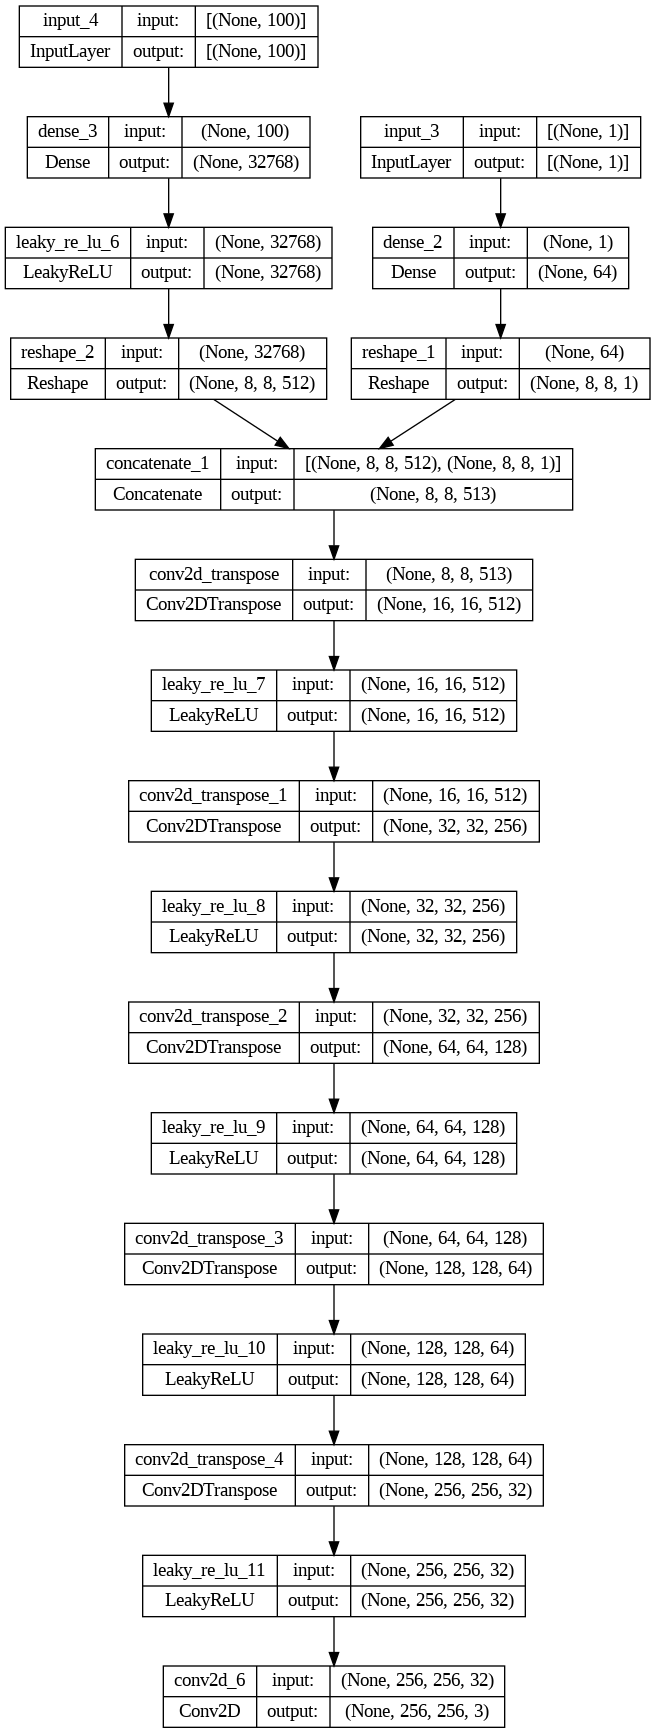

In [ ]:
# Visualize the model architecture
plot_model(generator, show_shapes=True, show_layer_names=True)

## Combined GAN

In [ ]:
def define_gan(g_model, d_model):
    # Set discriminator as not trainable, since it is trained separately
    d_model.trainable = False
    
    # Get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    
    # Get image output from the generator model
    gen_output = g_model.output
    
    # Generator image output and corresponding input label are inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    
    # Define GAN model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    
    # Compile model with binary cross-entropy loss and Adam optimizer
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

In [ ]:
gan = define_gan(generator, discriminator)
print(gan.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 32768)        3309568     ['input_4[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 leaky_re_lu_6 (LeakyReLU)      (None, 32768)        0           ['dense_3[0][0]']                
                                                                                            

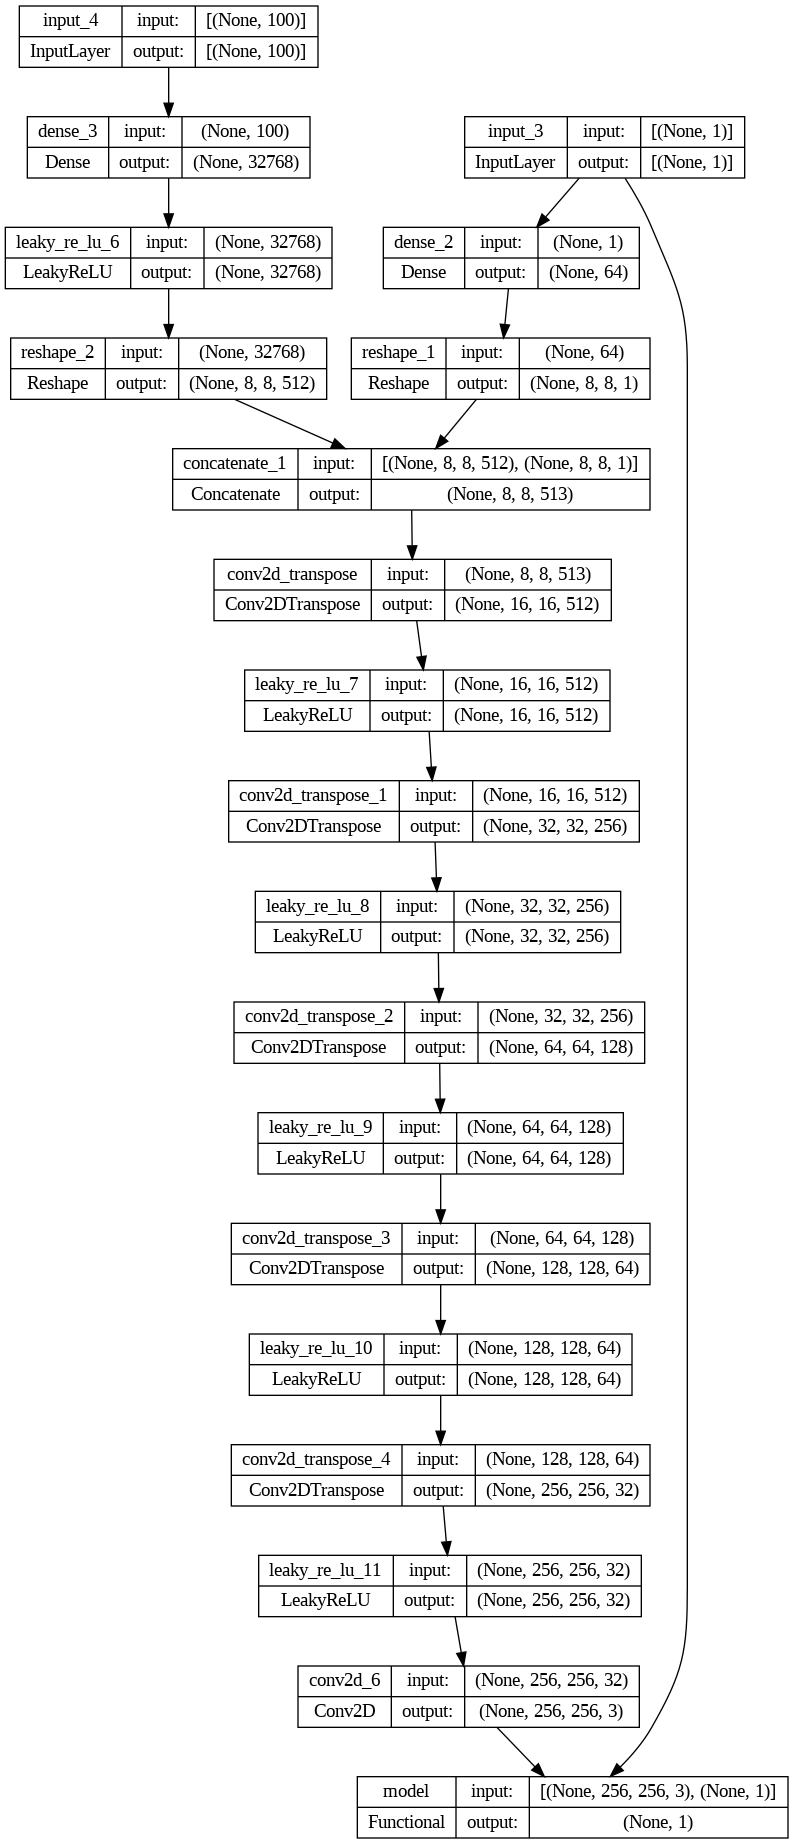

In [ ]:
# Visualize the model architecture
plot_model(gan, show_shapes=True, show_layer_names=True)

# Define Helper Functions

In [ ]:
def load_real_samples():
    # load dataset
    X, trainy = images_train, hs_train
    # convert to floats and scale
    X = X.astype('float32')
    # scale from [0,255] to [-1,1] to match the the output of generator
    X -= 127.5
    X /= 127.5 
    return [X, trainy]

In [ ]:
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset  
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels and assign to y (1=real image)
    y = ones((n_samples, 1))
    return [X, labels], y

In [ ]:
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = np.random.standard_normal(n_samples)
    return [z_input, labels]

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input], verbose = 0)
    # create class labels (0=fake image)
    y = zeros((n_samples, 1))
    return [images, labels_input], y

In [ ]:
def plot_to_image(figure):
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

In [ ]:
def generate_image_grid(model):
    # generate random points in the latent space
    latent_points, labels = generate_latent_points(100,100)

    # generate images from the latent points and labels using the generator model
    generated_images = model.predict([latent_points, labels], verbose = 0)

    # scale the pixel values from [-1,1] to [0,255]
    generated_images = (generated_images + 1) / 2.0 * 255
    generated_images = generated_images.astype(np.uint8)

    # create a grid of subplots to display the generated images
    fig, axs = plt.subplots(10,10, figsize=(14,14))

    # iterate through each label and plot the corresponding image
    for i, (image, label) in enumerate(zip(generated_images, labels)):
        ax = axs[i//10, i%10]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"HS {np.round(invert_standardization(label))}")

    plt.tight_layout()
    # plt.show()
    
    return fig

In [ ]:
def create_csv_gan (mean_combined_loss_list, mean_d_loss_real_list, mean_d_loss_fake_list, mean_g_loss_list, mean_combined_acc_list, mean_acc_fake_list, mean_acc_real_list):
    
    # Define file name
    csv_file = save_path + 'logs_losses/gan_losses.csv'

    # Define headers
    headers = ['Epoch', 'Combined Loss', 'D Loss Real', 'D Loss Fake', 'G Loss', 'Combined Acc', 'Acc Fake', 'Acc Real']

    # Create a list to hold all the mean loss and accuracy values for each epoch
    all_means = [mean_combined_loss_list, mean_d_loss_real_list, mean_d_loss_fake_list, mean_g_loss_list, mean_combined_acc_list, mean_acc_fake_list, mean_acc_real_list]

    # Open the file for writing
    with open(csv_file, 'w') as file:
        # Create a CSV writer
        writer = csv.writer(file)
        
        # Write headers
        writer.writerow(headers)
        
        # Loop through each epoch
        for i in range(len(mean_combined_loss_list)):
            # Create a list to hold the values for this epoch
            row = [i+1]
            # Loop through each mean value and append to the row
            for values in all_means:
                row.append(values[i])
            # Write the row to the CSV
            writer.writerow(row)

# Model Training (cGAN)

In [ ]:
save_path = "/path/256/HealthScore/"

# Sets up a log directory
log_dir = "logs/fit/"
# Create a file writer for the log directory
writer = tf.summary.create_file_writer(log_dir)

In [ ]:
# Create empty lists to hold loss values
mean_combined_loss_list = []
mean_d_loss_real_list = []
mean_d_loss_fake_list = []
mean_g_loss_list = []
mean_combined_acc_list = []
mean_acc_fake_list = []
mean_acc_real_list = []

In [ ]:
# Define data augmentation parameters
data_augmentation = ImageDataGenerator(
    rotation_range=10, # degree range for random rotations
    horizontal_flip=True, # randomly flip inputs horizontally
    fill_mode='nearest' # how to fill in any new pixels created during the augmentation
)

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    # Determine number of batches per epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # Determine the number of samples in each half batch
    half_batch = int(n_batch / 2)

    # Manually enumerate epochs
    for i in range(n_epochs):

      # Initialize the progress bar
        progress_bar = tqdm(range(bat_per_epo),position=0, leave=True, desc=f"Epoch {i+1}/{n_epochs}")

      # Create empty lists to hold loss values
        combined_loss_list = []
        d_loss_real_list = []
        d_loss_fake_list = []
        g_loss_list = []
        combined_acc_list = []
        acc_fake_list = []
        acc_real_list = []

        # Enumerate batches over the training set
        for index in progress_bar:
            # Train the discriminator on real and fake images, separately (half batch each)

            # Get randomly selected 'real' samples with labels
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

            # Apply data augmentation to the real samples
            X_real = data_augmentation.flow(X_real, batch_size=half_batch, shuffle=False).next()

            # Update discriminator model weights on the real samples
            d_loss_real, acc_real = d_model.train_on_batch([X_real, labels_real], y_real)

            # Generate 'fake' examples with labels
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

            # Update discriminator model weights on the fake samples
            d_loss_fake, acc_fake = d_model.train_on_batch([X_fake, labels], y_fake)

            # Prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

            # create array of real labels to fool the discriminator (hence value of 1 for y)
            y_gan = ones((n_batch, 1))

            # Update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)  

            # compute total loss and accuracy
            combined_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            combined_acc = 0.5 * np.add(acc_real, acc_fake)

            # Append loss values to respective lists
            combined_loss_list.append(combined_loss)
            d_loss_real_list.append(d_loss_real)
            d_loss_fake_list.append(d_loss_fake)
            g_loss_list.append(g_loss)
            combined_acc_list.append(combined_acc)
            acc_fake_list.append(acc_fake)
            acc_real_list.append(acc_real)

            # save lists as csv
            create_csv_gan(mean_combined_loss_list, mean_d_loss_real_list, mean_d_loss_fake_list, mean_g_loss_list, mean_combined_acc_list, mean_acc_fake_list, mean_acc_real_list)


            # Log losses to TensorBoard
            with writer.as_default():
                tf.summary.scalar('combined_loss', combined_loss, step=i)
                tf.summary.scalar('d_loss_real', d_loss_real, step=i)
                tf.summary.scalar('d_loss_fake', d_loss_fake, step=i)
                tf.summary.scalar('g_loss', g_loss, step=i)
                tf.summary.scalar('combined_acc', combined_acc, step=i)
                tf.summary.scalar('acc_fake', acc_fake, step=i)
                tf.summary.scalar('acc_real', acc_real, step=i)
                writer.flush()


            # Update the progress bar with the latest loss and ssim values
            progress_bar.set_postfix(g_loss=g_loss, d_loss_fake=d_loss_fake, d_loss_real=d_loss_real)

        # Get mean values and append to other lists
        mean_combined_loss = np.mean(combined_loss_list)
        mean_d_loss_real = np.mean(d_loss_real_list)
        mean_d_loss_fake = np.mean(d_loss_fake_list)
        mean_g_loss = np.mean(g_loss_list)
        mean_combined_acc = np.mean(combined_acc_list)
        mean_acc_fake = np.mean(acc_fake_list)
        mean_acc_real = np.mean(acc_real_list)

        mean_combined_loss_list.append(mean_combined_loss)
        mean_d_loss_real_list.append(mean_d_loss_real)
        mean_d_loss_fake_list.append(mean_d_loss_fake)
        mean_g_loss_list.append(mean_g_loss)
        mean_combined_acc_list.append(mean_combined_acc)
        mean_acc_fake_list.append(mean_acc_fake)
        mean_acc_real_list.append(mean_acc_real)


        if (i + 1) % 10 == 0:    
            # Prepare the plot
            figure = generate_image_grid(g_model)
            # save the figure
            figure.savefig(save_path + 'image_grids/image_grid_epoch_' + str(i+1) + '.png')
            # Convert to image and log
            with writer.as_default():
                tf.summary.image("Training data", plot_to_image(figure), step=i)

            # save the model with a different name for each epoch and include date and time
            now = datetime.now().strftime("%Y%m%d-%H%M%S")
            g_model.save(save_path + '/models/Generator/generator_epoch_' + str(i+1) + '_' + now + '.h5')
            d_model.save(save_path + '/models/Discriminator/discriminator_epoch_' + str(i+1) + '_' + now + '.h5')
            gan_model.save(save_path + '/models/cGan/gan_epoch_' + str(i+1) + '_' + now + '.h5')

        #manually save logs and models due to connection issues with Google Drive
        !zip -r /content/logs/fit.zip /content/logs/
        !cp /content/logs/fit.zip /content/drive/MyDrive


In [ ]:
# load image data
dataset = load_real_samples()

In [ ]:
# train model
train(generator, discriminator, gan, dataset, latent_dim=100, n_epochs=1)

Epoch 1/1: 100%|██████████| 144/144 [05:33<00:00,  2.32s/it, d_loss_fake=35.6, d_loss_real=2.21e-8, g_loss=11.1]


  adding: content/logs/ (stored 0%)
  adding: content/logs/fit/ (stored 0%)
  adding: content/logs/fit/events.out.tfevents.1681891292.0a62e4d5ce1d.1482.1.v2 (deflated 77%)
  adding: content/logs/fit/events.out.tfevents.1681887897.0a62e4d5ce1d.1482.0.v2 (deflated 5%)


In [ ]:
generator.save(save_path + '/models/Generator/generator_final.h5')
discriminator.save(save_path + '/models/Discriminator/discriminator_final.h5')
gan.save(save_path + '/models/cGan/gan_final.h5')

In [ ]:
# save lists as csv
create_csv_gan(mean_combined_loss_list, mean_d_loss_real_list, mean_d_loss_fake_list, mean_g_loss_list, mean_combined_acc_list, mean_acc_fake_list, mean_acc_real_list)

In [ ]:
# create image grid once training is finished
figure = generate_image_grid(generator)

# Define Model Architecture (Encoder)

## Define Encoder

In [ ]:
# define dimensions

img_rows, img_cols, img_chns = 256, 256, 3
latent_dim = 100
original_dim = 256*256*3

In [ ]:
def build_encoder():
    
    input_layer = Input(shape=(256, 256, 3))
    
    # 1st Convolutional Block
    enc = Conv2D(filters=32, kernel_size=5, strides=2, padding='same')(input_layer)
    enc = LeakyReLU(alpha=0.2)(enc)
    
    # 2nd Convolutional Block
    enc = Conv2D(filters=64, kernel_size=5, strides=2, padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = LeakyReLU(alpha=0.2)(enc)
    
    # 3rd Convolutional Block
    enc = Conv2D(filters=128, kernel_size=4, strides=2, padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = LeakyReLU(alpha=0.2)(enc)
    
    # 4th Convolutional Block
    enc = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = LeakyReLU(alpha=0.2)(enc)
    
    # 5th Convolutional Block
    enc = Conv2D(filters=512, kernel_size=2, strides=2, padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = LeakyReLU(alpha=0.2)(enc)
    
    # 5th Convolutional Block
    enc = Conv2D(filters=1024, kernel_size=2, strides=2, padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = LeakyReLU(alpha=0.2)(enc)
    
    # Flatten layer
    enc = Flatten()(enc)
    
    # 1st Fully Connected Layer
    enc = Dense(1024)(enc)
    enc = BatchNormalization()(enc)
    enc = LeakyReLU(alpha=0.2)(enc)
    
    # Second Fully Connected Layer
    enc = Dense(100)(enc)
    
    # Create a model
    model = Model(inputs=[input_layer], outputs=[enc])
    return model

## Define Helper Functions

In [ ]:
# Define function to calculate Euclidean distance loss
def euclidean_distance_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [ ]:
# Define function to calculate the Structural Similarity Index
def SSIM(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 255.00))

In [ ]:
def create_image_grid(images1, images2, labels, similarity):
    fig, axs = plt.subplots(10, 2, figsize=(10, 24))
    
    for i in range(10):
        axs[i, 0].imshow(images1[i])
        axs[i, 0].axis('off')
        axs[i, 0].set_title(f"Original HS: {labels[i]}")
        
        axs[i, 1].imshow(images2[i])
        axs[i, 1].axis('off')
        axs[i, 1].set_title(f"Generated SSIM: {similarity[i]}")
    
    plt.tight_layout()
    return fig

In [ ]:
def create_csv_encoder(mean_loss, mean_ssim):

    # Define file name
    csv_file = save_path + 'logs_losses/losses_encoder.csv'

    # Define headers
    headers = ['Epoch', 'MSE', 'SSIM']

    # Create a list to hold all the mean loss and accuracy values for each epoch
    all_means = [mean_loss, mean_ssim]

    # Open the file for writing
    with open(csv_file, 'w') as file:
        # Create a CSV writer
        writer = csv.writer(file)
        
        # Write headers
        writer.writerow(headers)
        
        # Loop through each epoch
        for i in range(len(mean_loss)):
            # Create a list to hold the values for this epoch
            row = [i+1]
            # Loop through each mean value and append to the row
            for values in all_means:
                row.append(values[i])
            # Write the row to the CSV
            writer.writerow(row)

    print("Sucessfully saved CSV!")

## Build Encoder

In [ ]:
# Build Encoder
encoder = build_encoder()
encoder.compile(loss=euclidean_distance_loss, optimizer='adam')
print(encoder.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      2432      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 128, 128, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        51264     
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                           

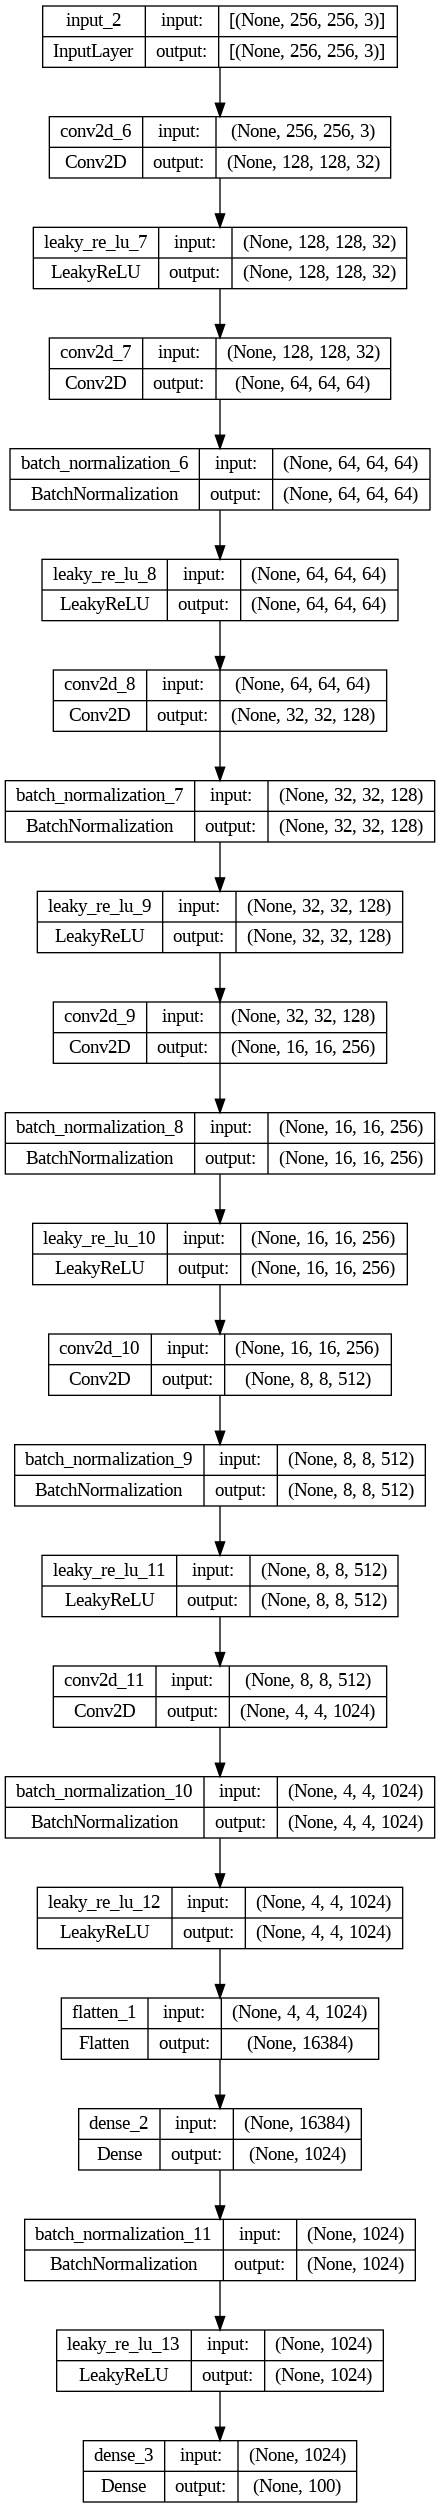

In [ ]:
# Visualize the model architecture
plot_model(encoder, show_shapes=True, show_layer_names=True)

# Model Training (Encoder)

In [ ]:
# load generator
generator = load_model('/path/256/HealthScore/models/Generator/generator_epoch_260.h5')

In [ ]:
# Define the loss function
mse_loss = tf.keras.losses.MeanSquaredError()

# Define the optimizer
optimizer = tf.keras.optimizers.Adam()

In [ ]:
# Initialize TensorBoard
log_dir = save_path + "logs_losses/encoder/"
writer = tf.summary.create_file_writer(log_dir)

# Define training parameters
num_epochs = 50
batch_size = 128

# Define list for losses
mean_loss = []
mean_ssim = []

# Define images that are used to evaluate the model every 10 epochs
val_imgages = images_test[:10]
val_labels = hs_test[:10]

In [ ]:
# Define the training loop
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        # Pass the input images through the encoder
        encoded = encoder(inputs, training=True)
        
        # Generate images using the pre-trained generator
        generated = generator([encoded, labels], training=False)

        # Rescale pixels to [0,255]
        generated = (generated + 1) / 2.0
        generated = generated * 255

        # Change format of input values
        inputs = tf.cast(inputs, tf.float32)
      
        # Compute the loss between the original images and the generated images
        loss = mse_loss(inputs, generated)

        ssim_v = tf.reduce_mean(tf.image.ssim(inputs, generated, 255.00))
    
    # Compute the gradients of the loss with respect to the encoder's trainable variables
    gradients = tape.gradient(loss, encoder.trainable_variables)
    
    # Update the encoder's trainable variables using the optimizer
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables))
    
    # Return the loss & ssim value
    return loss, ssim_v

In [ ]:
# Train the encoder

for epoch in range(num_epochs):
    number_of_batches = int(len(images_train) / batch_size)

    epoch_loss = []
    epoch_ssim = []

    # Initialize the progress bar
    progress_bar = tqdm(range(number_of_batches), desc=f"Epoch {epoch+1}/{num_epochs}")

    for index in progress_bar:
        # Load one batch of images and scales pixels to [-1,1]
        images_batch = images_train[index * batch_size:(index + 1) * batch_size]

        # Load corresponding label
        y_batch = hs_train[index * batch_size:(index + 1) * batch_size]

        # Apply training loop for one batch
        loss, ssim_v = train_step(inputs = images_batch, labels = y_batch)

        # Append values to loss and SSIM to list
        epoch_loss.append(loss)
        epoch_ssim.append(ssim_v)

        # Log losses to TensorBoard
        with writer.as_default():
            tf.summary.scalar('Encoder Loss', loss, step=epoch)
            tf.summary.scalar('SSIM', ssim_v, step=epoch)
            writer.flush()

        # Update the progress bar with the latest loss and ssim values
        progress_bar.set_postfix(loss=loss.numpy(), ssim=ssim_v.numpy())

    mean_loss.append(np.mean(epoch_loss))
    mean_ssim.append(np.mean(epoch_ssim))


    if (epoch + 1) % 10 == 0:


        val_encoded = encoder.predict(val_imgages, verbose = 0)
        val_generated = generator.predict([val_encoded, val_labels], verbose = 0)

        # Rescale pixels to [0,255]
        val_generated = (val_generated + 1) / 2.0
        val_generated = val_generated * 255

        generated_images = generated_images.astype(np.uint8)
        val_imgages = val_imgages.astype(np.uint8)
        
        similartiy_index = tf.image.ssim(val_imgages, generated_images, 255.00)
        similartiy_index = np.round(similartiy_index, 4)


        # Prepare the plot for validation images
        sample_grid = create_image_grid(val_imgages, generated_images,  val_labels, similartiy_index)
        # save the figure
        sample_grid.savefig(save_path + 'image_grids/image_grid_encoder_epoch_' + str(epoch+1) + '.png')
        # Convert to image and log
        with writer.as_default():
            tf.summary.image("Validation Grid", plot_to_image(sample_grid), step=epoch)

        # save the model with a different name for each epoch and include date and time
        now = datetime.now().strftime("%Y%m%d-%H%M%S")
        encoder.save(save_path + 'models/Encoder/encoder_' + str(epoch+1) + '_' + now + '.h5')

Epoch 50/50: 100%|██████████| 289/289 [00:30<00:00,  9.49it/s, loss=342, ssim=0.633]


In [ ]:
encoder.save(save_path + 'models/Encoder/encoder_final.h5')

In [ ]:
create_csv_encoder(mean_loss, mean_ssim)

Sucessfully saved CSV!


# Evaluation


In [ ]:
encoder = load_model(save_path + 'models/Encoder/encoder_final.h5', custom_objects={'euclidean_distance_loss':euclidean_distance_loss})
generator = load_model('/path/256/HealthScore/models/Generator/generator_epoch_260.h5')

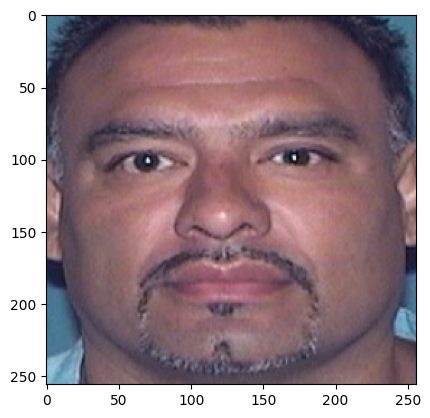

In [ ]:
img = 122
plt.imshow(images_test[img:img+1][0])

In [ ]:
print("HS: ", hs_test[img:img+1])
print("BMI: ", bmi_test[img:img+1])

HS:  [476]
BMI:  [30.99242966]


In [ ]:
latent_vector = encoder.predict(images_test[img:img+1])

1/1 [==============================] - 8s 8s/step


In [ ]:
# use corresponding HS to BMI values from 21 - 40
hs_labels_test = [516,512,506,501,495,489,482,476,469,462,455,448,441,434,427,420]
hs_labels_test_s = (hs_labels_test - hs_train_mean) / hs_train_std

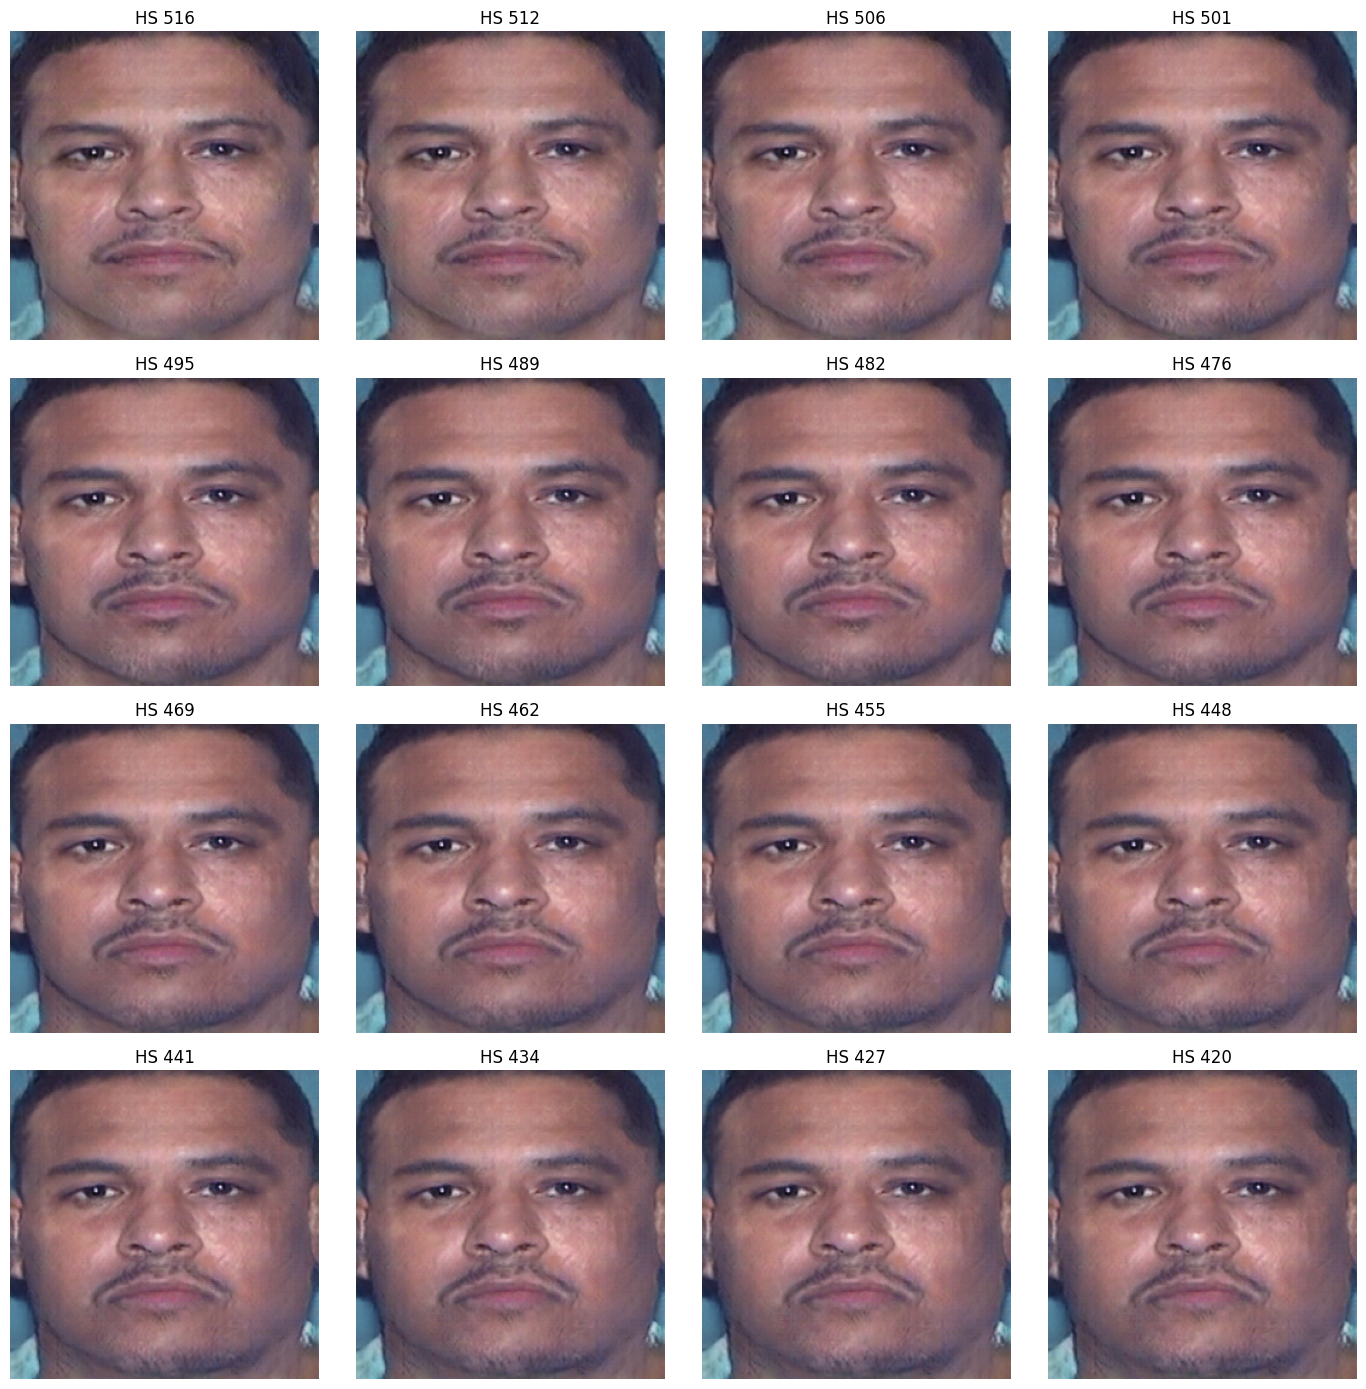

In [ ]:
# create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(14,14))

# iterate through each label and plot the corresponding image
for label, label_s, ax in zip(hs_labels_test,hs_labels_test_s, axs.flatten()):
    label_s = np.array([label_s])
    X = generator.predict([latent_vector, label_s],verbose = 0)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    X = (X * 255).astype(np.uint8)
    ax.imshow(X[0])
    ax.set_title(f"HS {label}")
    ax.set_axis_off()

plt.tight_layout()
plt.show()